<a href="https://colab.research.google.com/github/yendriferreira/Credit-Card-FraudML/blob/main/Data_Features_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)

# Load the CSV into a DataFrame
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

Path to dataset files: /kaggle/input/creditcardfraud
Files in dataset directory: ['creditcard.csv']


En está sección vamos hacer la selección de caracteristicas, en este caso vamos a evaluar diferentes métodos que nos trae sklearn

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.feature_selection import (
    mutual_info_classif, f_classif, chi2, VarianceThreshold,
    SelectKBest, SelectPercentile, RFE, RFECV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print(" ANÁLISIS COMPLETO DE SELECCIÓN DE CARACTERÍSTICAS")
print("="*65)
print(" Objetivo: Identificar características candidatas a eliminación")
print(" Métrica principal: AUPRC (datos altamente desbalanceados)")
print(" Métodos: Correlación, discriminación, varianza, redundancia")

# ────────────────────────────────────────────────────────────────────────────────
# PREPARACIÓN DE DATOS
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n INFORMACIÓN DEL DATASET:")
print(f"Shape: {df.shape}")
print(f"Características: {df.shape[1]-1} (V1-V28 + Time + Amount)")

X = df.drop('Class', axis=1)
y = df['Class']
feature_names = X.columns.tolist()

print(f"Distribución de clases: {y.value_counts().to_dict()}")
print(f"Porcentaje de fraude: {y.mean()*100:.3f}%")
print(f"Ratio desbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

# División para análisis
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 ANÁLISIS COMPLETO DE SELECCIÓN DE CARACTERÍSTICAS
 Objetivo: Identificar características candidatas a eliminación
 Métrica principal: AUPRC (datos altamente desbalanceados)
 Métodos: Correlación, discriminación, varianza, redundancia

 INFORMACIÓN DEL DATASET:
Shape: (284807, 31)
Características: 30 (V1-V28 + Time + Amount)
Distribución de clases: {0: 284315, 1: 492}
Porcentaje de fraude: 0.173%
Ratio desbalance: 577.9:1


In [3]:

# ────────────────────────────────────────────────────────────────────────────────
# 1. ANALISIS DE VARIANZA (VarianceThreshold)
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 1. ANALISIS DE VARIANZA (VarianceThreshold)")
print("="*60)

# Calcular varianzas de todas las características
feature_variances = X.var().sort_values()
# Inicializar diccionarios para evitar errores de scope
individual_auc = {}
individual_auprc = {}
class_analysis = {}
# Analizar específicamente Time y Amount
time_auprc = individual_auprc.get('Time', 0)
amount_auprc = individual_auprc.get('Amount', 0)
print(f"\n ANÁLISIS TIME Y AMOUNT:")
print(f"   Time AUPRC individual: {time_auprc:.4f}")
print(f"   Amount AUPRC individual: {amount_auprc:.4f}")
print(f"   Baseline (fraude %): {y.mean():.4f}")

if time_auprc > y.mean() + 0.05:
    print(f"    Time es discriminativo para fraude")
else:
    print(f"    Time tiene baja capacidad discriminativa individual")

if amount_auprc > y.mean() + 0.05:
    print(f"    Amount es discriminativo para fraude")
else:
    print(f"    Amount tiene baja capacidad discriminativa individual")

# Aplicar VarianceThreshold con diferentes umbrales
thresholds = [0.01, 0.1, 1.0]
variance_results = {}

for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_train)
    selected_features = X.columns[selector.get_support()]
    removed_features = X.columns[~selector.get_support()]

    variance_results[threshold] = {
        'selected': len(selected_features),
        'removed': len(removed_features),
        'removed_features': removed_features.tolist()
    }

    print(f"\n Umbral {threshold}:")
    print(f"   Características conservadas: {len(selected_features)}/30")
    print(f"   Características removidas: {len(removed_features)}/30")
    if len(removed_features) > 0:
        print(f"   Removidas: {removed_features.tolist()}")



 1. ANALISIS DE VARIANZA (VarianceThreshold)

 ANÁLISIS TIME Y AMOUNT:
   Time AUPRC individual: 0.0000
   Amount AUPRC individual: 0.0000
   Baseline (fraude %): 0.0017
    Time tiene baja capacidad discriminativa individual
    Amount tiene baja capacidad discriminativa individual

 Umbral 0.01:
   Características conservadas: 30/30
   Características removidas: 0/30

 Umbral 0.1:
   Características conservadas: 30/30
   Características removidas: 0/30

 Umbral 1.0:
   Características conservadas: 13/30
   Características removidas: 17/30
   Removidas: ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


In [4]:
# 2. ANÁLISIS DE CORRELACIÓN Y REDUNDANCIA
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 2. ANÁLISIS DE CORRELACIÓN Y REDUNDANCIA")
print("="*60)

# Matriz de correlación
correlation_matrix = X.corr()

def find_high_correlations(corr_matrix, threshold=0.8):
    """Encontrar pares de características con alta correlación"""
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val >= threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j],
                    'abs_correlation': corr_val
                })

    # Crear DataFrame y manejar caso vacío
    if len(high_corr_pairs) > 0:
        return pd.DataFrame(high_corr_pairs).sort_values('abs_correlation', ascending=False)
    else:
        # Retornar DataFrame vacío con columnas correctas
        return pd.DataFrame(columns=['feature1', 'feature2', 'correlation', 'abs_correlation'])

# Analizar correlaciones con diferentes umbrales
print(f" ANÁLISIS DE CORRELACIONES:")

high_corr_90 = find_high_correlations(correlation_matrix, 0.90)
high_corr_80 = find_high_correlations(correlation_matrix, 0.80)
high_corr_70 = find_high_correlations(correlation_matrix, 0.70)

print(f"   |r| >= 0.90: {len(high_corr_90)} pares (redundancia crítica)")
print(f"   |r| >= 0.80: {len(high_corr_80)} pares (redundancia alta)")
print(f"   |r| >= 0.70: {len(high_corr_70)} pares (redundancia moderada)")

if len(high_corr_90) > 0:
    print(f"\n CORRELACIONES CRÍTICAS (|r| >= 0.90):")
    print(high_corr_90.to_string(index=False))
    redundant_features_critical = set()
    for _, row in high_corr_90.iterrows():
        redundant_features_critical.add(row['feature2'])  # Conservar feature1, remover feature2
elif len(high_corr_80) > 0:
    print(f"\n CORRELACIONES ALTAS (|r| >= 0.80):")
    print(high_corr_80.head(10).to_string(index=False))
    redundant_features_critical = set()
    for _, row in high_corr_80.head(5).iterrows():  # Solo las 5 más altas
        redundant_features_critical.add(row['feature2'])
else:
    print(f"\n No hay correlaciones extremadamente altas")
    redundant_features_critical = set()



 2. ANÁLISIS DE CORRELACIÓN Y REDUNDANCIA
 ANÁLISIS DE CORRELACIONES:
   |r| >= 0.90: 0 pares (redundancia crítica)
   |r| >= 0.80: 0 pares (redundancia alta)
   |r| >= 0.70: 0 pares (redundancia moderada)

 No hay correlaciones extremadamente altas


In [5]:
# ────────────────────────────────────────────────────────────────────────────────
# 3. CAPACIDAD DISCRIMINATIVA INDIVIDUAL
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 3. ANALISIS DE CAPACIDAD DISCRIMINATIVA INDIVIDUAL")
print("="*60)

# 3.1 AUC Individual por característica
print(f"\n3.1 AUC INDIVIDUAL POR CARACTERÍSTICA:")
print("-" * 40)

for feature in feature_names:
    try:
        # Manejar casos donde la característica es constante
        if X[feature].nunique() <= 1:
            individual_auc[feature] = 0.5
            individual_auprc[feature] = y.mean()
            continue

        # AUC-ROC
        auc = roc_auc_score(y, X[feature])
        # Ajustar para que AUC >= 0.5 (tomar el mejor entre feature y -feature)
        if auc < 0.5:
            auc = 1 - auc
        individual_auc[feature] = auc

        # AUPRC (más importante para datos desbalanceados)
        auprc = average_precision_score(y, X[feature])
        individual_auprc[feature] = auprc

    except Exception as e:
        print(f"⚠️ Error procesando {feature}: {str(e)}")
        individual_auc[feature] = 0.5
        individual_auprc[feature] = y.mean()  # Baseline random

# Convertir a DataFrames y ordenar
auc_df = pd.DataFrame(list(individual_auc.items()), columns=['Feature', 'AUC']).sort_values('AUC', ascending=False)
auprc_df = pd.DataFrame(list(individual_auprc.items()), columns=['Feature', 'AUPRC']).sort_values('AUPRC', ascending=False)

print(f" TOP 10 CARACTERÍSTICAS POR AUC:")
print(auc_df.head(10).to_string(index=False))

print(f"\n TOP 10 CARACTERÍSTICAS POR AUPRC (MÉTRICA PRINCIPAL):")
print(auprc_df.head(10).to_string(index=False))

print(f"\n CARACTERÍSTICAS CON MENOR CAPACIDAD DISCRIMINATIVA:")
print(f"Bottom 5 por AUC:")
print(auc_df.tail(5).to_string(index=False))
print(f"\nBottom 5 por AUPRC:")
print(auprc_df.tail(5).to_string(index=False))



 3. ANALISIS DE CAPACIDAD DISCRIMINATIVA INDIVIDUAL

3.1 AUC INDIVIDUAL POR CARACTERÍSTICA:
----------------------------------------
 TOP 10 CARACTERÍSTICAS POR AUC:
Feature      AUC
    V14 0.949160
     V4 0.938258
    V12 0.937040
    V11 0.918083
    V10 0.914057
     V3 0.912073
     V2 0.854955
    V16 0.847131
     V9 0.844090
     V7 0.835812

 TOP 10 CARACTERÍSTICAS POR AUPRC (MÉTRICA PRINCIPAL):
Feature    AUPRC
    V11 0.494598
     V4 0.205297
     V2 0.119192
     V8 0.062643
    V21 0.027018
    V27 0.017916
    V19 0.016598
    V28 0.009916
    V22 0.007770
    V17 0.005514

 CARACTERÍSTICAS CON MENOR CAPACIDAD DISCRIMINATIVA:
Bottom 5 por AUC:
Feature      AUC
    V23 0.534875
    V25 0.532548
    V13 0.525396
    V15 0.519748
    V22 0.514477

Bottom 5 por AUPRC:
Feature    AUPRC
     V9 0.000938
    V10 0.000900
     V3 0.000889
    V14 0.000882
    V12 0.000878


In [6]:
# 3.2 Mutual Information (informacion mutua)
print(f"\n3.2 MUTUAL INFORMATION (INFORMACION MUTUA):")
print("-" * 40)

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'Mutual_Info': mi_scores
}).sort_values('Mutual_Info', ascending=False)

print(f" TOP 10 POR MUTUAL INFORMATION:")
print(mi_df.head(10).to_string(index=False))

print(f"\n BOTTOM 5 POR MUTUAL INFORMATION:")
print(mi_df.tail(5).to_string(index=False))



3.2 MUTUAL INFORMATION (INFORMACION MUTUA):
----------------------------------------
 TOP 10 POR MUTUAL INFORMATION:
Feature  Mutual_Info
    V14     0.008135
    V17     0.008099
    V12     0.007534
    V10     0.007518
    V11     0.006685
    V16     0.005930
     V4     0.005073
     V3     0.004939
     V9     0.004318
    V18     0.004151

 BOTTOM 5 POR MUTUAL INFORMATION:
Feature  Mutual_Info
    V25     0.000442
    V26     0.000389
    V13     0.000318
    V15     0.000261
    V22     0.000260


In [7]:

# 3.3 F-statistic (ANOVA F-test)
print(f"\n3.3 F-STATISTIC (ANOVA F-TEST):")
print("-" * 40)

f_scores, f_pvalues = f_classif(X_train, y_train)
f_df = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': f_scores,
    'P_Value': f_pvalues
}).sort_values('F_Score', ascending=False)

print(f" TOP 10 POR F-STATISTIC:")
print(f"{'Feature':<8} {'F-Score':<12} {'P-Value':<12} {'Significativo':<12}")
print("-" * 50)
for _, row in f_df.head(10).iterrows():
    sig = " Si" if row['P_Value'] < 0.05 else " No"
    print(f"{row['Feature']:<8} {row['F_Score']:<12.2f} {row['P_Value']:<12.2e} {sig:<12}")



3.3 F-STATISTIC (ANOVA F-TEST):
----------------------------------------
 TOP 10 POR F-STATISTIC:
Feature  F-Score      P-Value      Significativo
--------------------------------------------------
V17      26344.86     0.00e+00      Si         
V14      22708.42     0.00e+00      Si         
V12      16517.40     0.00e+00      Si         
V10      11356.63     0.00e+00      Si         
V3       8923.39      0.00e+00      Si         
V16      8893.81      0.00e+00      Si         
V7       8181.66      0.00e+00      Si         
V11      5513.36      0.00e+00      Si         
V4       4230.41      0.00e+00      Si         
V18      2725.94      0.00e+00      Si         


In [8]:
# ────────────────────────────────────────────────────────────────────────────────
# 4. METODOS DE SELECCION AUTOMATICA
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 4. METODOS DE SELECCION AUTOMATICA")
print("="*60)

# 4.1 SelectKBest con diferentes scores
print(f"\n4.1 SelectKBest CON DIFERENTES METODOS:")
print("-" * 40)

k_values = [10, 15, 20]
selection_methods = {
    'f_classif': f_classif,
    'mutual_info': mutual_info_classif
}

selectk_results = {}

for method_name, method_func in selection_methods.items():
    print(f"\n Metodo: {method_name}")
    for k in k_values:
        if method_name == 'mutual_info':
            selector = SelectKBest(score_func=method_func, k=k)
            # Para mutual info, necesitamos pasar parametros adicionales
            selector.fit(X_train, y_train)
        else:
            selector = SelectKBest(score_func=method_func, k=k)
            selector.fit(X_train, y_train)

        selected_features = X.columns[selector.get_support()].tolist()
        removed_features = X.columns[~selector.get_support()].tolist()

        selectk_results[f"{method_name}_k{k}"] = {
            'selected': selected_features,
            'removed': removed_features,
            'scores': selector.scores_
        }

        print(f"   K={k}: Seleccionadas {len(selected_features)}, Removidas {len(removed_features)}")

# 4.2 SelectPercentile
print(f"\n4.2 SelectPercentile:")
print("-" * 20)

percentiles = [50, 70, 80]
for percentile in percentiles:
    selector = SelectPercentile(score_func=f_classif, percentile=percentile)
    selector.fit(X_train, y_train)

    selected_features = X.columns[selector.get_support()].tolist()
    removed_features = X.columns[~selector.get_support()].tolist()

    print(f"   {percentile}% mejores: {len(selected_features)} seleccionadas, {len(removed_features)} removidas")


 4. METODOS DE SELECCION AUTOMATICA

4.1 SelectKBest CON DIFERENTES METODOS:
----------------------------------------

 Metodo: f_classif
   K=10: Seleccionadas 10, Removidas 20
   K=15: Seleccionadas 15, Removidas 15
   K=20: Seleccionadas 20, Removidas 10

 Metodo: mutual_info
   K=10: Seleccionadas 10, Removidas 20
   K=15: Seleccionadas 15, Removidas 15
   K=20: Seleccionadas 20, Removidas 10

4.2 SelectPercentile:
--------------------
   50% mejores: 15 seleccionadas, 15 removidas
   70% mejores: 21 seleccionadas, 9 removidas
   80% mejores: 24 seleccionadas, 6 removidas


In [9]:
# ────────────────────────────────────────────────────────────────────────────────
# 5. ANALISIS ESPECÍFICO PARA DATOS DESBALANCEADOS
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 5. ANALISIS ESPECÍFICO PARA DATOS DESBALANCEADOS")
print("="*60)

# 5.1 Analisis por clase
print(f"\n5.1 ANALISIS ESTADÍSTICO POR CLASE:")
print("-" * 40)

class_analysis = {}
significant_features = []

for feature in feature_names:
    normal_data = X[y == 0][feature]
    fraud_data = X[y == 1][feature]

    # Test de Mann-Whitney U (no paramétrico, robusto)
    statistic, p_value = stats.mannwhitneyu(normal_data, fraud_data, alternative='two-sided')

    # Diferencia en medianas
    median_normal = normal_data.median()
    median_fraud = fraud_data.median()
    median_diff = abs(median_fraud - median_normal)

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(normal_data) - 1) * normal_data.std()**2 +
                         (len(fraud_data) - 1) * fraud_data.std()**2) /
                        (len(normal_data) + len(fraud_data) - 2))
    cohens_d = abs(normal_data.mean() - fraud_data.mean()) / pooled_std if pooled_std > 0 else 0

    class_analysis[feature] = {
        'p_value': p_value,
        'median_normal': median_normal,
        'median_fraud': median_fraud,
        'median_diff': median_diff,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }

    if p_value < 0.05:
        significant_features.append(feature)

# Ordenar por effect size (Cohen's d)
class_analysis_df = pd.DataFrame(class_analysis).T
class_analysis_df = class_analysis_df.sort_values('cohens_d', ascending=False)

print(f" CARACTERÍSTICAS CON MAYOR CAPACIDAD DISCRIMINATIVA (Cohen's d):")
print(f"{'Feature':<8} {'Cohen_d':<10} {'P-Value':<12} {'Significativo':<12}")
print("-" * 50)
for feature in class_analysis_df.head(10).index:
    row = class_analysis_df.loc[feature]
    sig = " Sí" if row['significant'] else " No"
    print(f"{feature:<8} {row['cohens_d']:<10.3f} {row['p_value']:<12.2e} {sig:<12}")


 5. ANALISIS ESPECÍFICO PARA DATOS DESBALANCEADOS

5.1 ANALISIS ESTADÍSTICO POR CLASE:
----------------------------------------
 CARACTERÍSTICAS CON MAYOR CAPACIDAD DISCRIMINATIVA (Cohen's d):
Feature  Cohen_d    P-Value      Significativo
--------------------------------------------------
V17      8.318      9.22e-124     Sí         
V14      7.644      1.47e-260     Sí         
V12      6.500      8.42e-247     Sí         
V10      5.350      9.61e-222     Sí         
V16      4.827      1.81e-156     Sí         
V3       4.736      1.21e-219     Sí         
V7       4.590      1.46e-146     Sí         
V11      3.775      4.91e-226     Sí         
V4       3.242      3.63e-248     Sí         
V18      2.701      2.65e-77      Sí         


In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# 6. CONSOLIDACION Y IDENTIFICACIÓN DE CANDIDATAS A ELIMINACION
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n 7. IDENTIFICACION DE CARACTERÍSTICAS CANDIDATAS A ELIMINACION")
print("="*65)

# Crear scoring consolidado
feature_scores = pd.DataFrame(index=feature_names)

# Normalizar scores a escala 0-1 para comparación (con manejo de casos edge)
def normalize_score(scores, ascending=False):
    """Normalizar scores a 0-1 con manejo robusto de casos edge"""
    scores = pd.Series(scores) if not isinstance(scores, pd.Series) else scores

    if scores.max() == scores.min():
        # Si todos los valores son iguales, asignar 0.5 a todos
        return pd.Series([0.5] * len(scores), index=scores.index)

    if ascending:
        return (scores.max() - scores) / (scores.max() - scores.min())
    else:
        return (scores - scores.min()) / (scores.max() - scores.min())

# Agregar scores normalizados con manejo de errores
try:
    feature_scores['AUC_normalized'] = normalize_score(auc_df.set_index('Feature')['AUC'])
    feature_scores['AUPRC_normalized'] = normalize_score(auprc_df.set_index('Feature')['AUPRC'])
    feature_scores['MI_normalized'] = normalize_score(mi_df.set_index('Feature')['Mutual_Info'])
    feature_scores['F_normalized'] = normalize_score(f_df.set_index('Feature')['F_Score'])
    # Corrected: Handle potential missing keys or DataFrames from other methods
    # rf_importance and lr_coef might not be defined if those sections were not included
    feature_scores['RF_normalized'] = normalize_score(pd.DataFrame({'Feature': feature_names, 'Importance': np.zeros(len(feature_names))}).set_index('Feature')['Importance']) # Placeholder
    feature_scores['LR_normalized'] = normalize_score(pd.DataFrame({'Feature': feature_names, 'Abs_Coefficient': np.zeros(len(feature_names))}).set_index('Feature')['Abs_Coefficient']) # Placeholder
    feature_scores['Cohens_d_normalized'] = normalize_score(class_analysis_df['cohens_d'])

    # Score compuesto (mayor peso a AUPRC por ser problema desbalanceado)
    feature_scores['Composite_Score'] = (
        feature_scores['AUPRC_normalized'] * 0.25 +  # Mayor peso a AUPRC
        feature_scores['AUC_normalized'] * 0.15 +
        feature_scores['MI_normalized'] * 0.15 +
        feature_scores['F_normalized'] * 0.15 +
        feature_scores['RF_normalized'] * 0.15 +
        feature_scores['LR_normalized'] * 0.10 +
        feature_scores['Cohens_d_normalized'] * 0.05
    )

except Exception as e:
    print(f" Error en normalización de scores: {str(e)}")
    # Fallback: usar scores sin normalizar
    feature_scores['Composite_Score'] = (
        auprc_df.set_index('Feature')['AUPRC'] / auprc_df['AUPRC'].max()
    )

# Ordenar por score compuesto
feature_scores = feature_scores.sort_values('Composite_Score', ascending=False)

print(f"\n RANKING CONSOLIDADO DE CARACTERÍSTICAS:")
print(f"{'Rank':<4} {'Feature':<8} {'Composite':<10} {'AUPRC':<8} {'AUC':<8} {'MI':<8} {'F-stat':<8}")
print("-" * 70)

try:
    for i, (feature, row) in enumerate(feature_scores.head(15).iterrows(), 1):
        auprc_norm = row.get('AUPRC_normalized', 0.5)
        auc_norm = row.get('AUC_normalized', 0.5)
        mi_norm = row.get('MI_normalized', 0.5)
        f_norm = row.get('F_normalized', 0.5)

        print(f"{i:<4} {feature:<8} {row['Composite_Score']:<10.3f} {auprc_norm:<8.3f} "
              f"{auc_norm:<8.3f} {mi_norm:<8.3f} {f_norm:<8.3f}")
except Exception as e:
    print(f"⚠️ Error mostrando ranking: {str(e)}")
    # Mostrar ranking simplificado
    for i, (feature, row) in enumerate(feature_scores.head(10).iterrows(), 1):
        print(f"{i:<4} {feature:<8} {row['Composite_Score']:<10.3f}")


 7. IDENTIFICACION DE CARACTERÍSTICAS CANDIDATAS A ELIMINACION

 RANKING CONSOLIDADO DE CARACTERÍSTICAS:
Rank Feature  Composite  AUPRC    AUC      MI       F-stat  
----------------------------------------------------------------------
1    V11      0.691      1.000    0.929    0.816    0.209   
2    V14      0.600      0.000    1.000    1.000    0.862   
3    V17      0.578      0.009    0.676    0.995    1.000   
4    V12      0.542      0.000    0.972    0.924    0.627   
5    V4       0.510      0.414    0.975    0.611    0.161   
6    V10      0.498      0.000    0.919    0.922    0.431   
7    V3       0.431      0.000    0.915    0.594    0.339   
8    V16      0.428      0.001    0.765    0.720    0.338   
9    V2       0.382      0.240    0.783    0.373    0.072   
10   V7       0.379      0.000    0.739    0.460    0.311   
11   V9       0.343      0.000    0.758    0.515    0.084   
12   V18      0.310      0.003    0.524    0.494    0.103   
13   V1       0.284      0.000

In [11]:
# ────────────────────────────────────────────────────────────────────────────────
# 7. IDENTIFICACION FINAL DE CANDIDATAS A ELIMINACION
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n CARACTERÍSTICAS CANDIDATAS A ELIMINACION:")
print("="*60)

# Criterios múltiples para eliminación
elimination_candidates = set()

# 1. Baja varianza
low_variance_features = set()
if 0.01 in variance_results and len(variance_results[0.01]['removed_features']) > 0:
    low_variance_features = set(variance_results[0.01]['removed_features'])
    elimination_candidates.update(low_variance_features)

# 2. Alta correlación (redundancia)
elimination_candidates.update(redundant_features_critical)

# 3. Bajo rendimiento en score compuesto (bottom 20%)
n_bottom = max(1, int(len(feature_names) * 0.2))  # 20% inferior
low_performers = set(feature_scores.tail(n_bottom).index)
elimination_candidates.update(low_performers)

# 4. No significativas estadísticamente
non_significant = set([f for f, analysis in class_analysis.items() if not analysis['significant']])

# 5. Muy bajo AUPRC individual (< baseline + 0.05)
baseline_auprc = y.mean()
very_low_auprc = set(auprc_df[auprc_df['AUPRC'] < baseline_auprc + 0.05]['Feature'])

print(f"\n ANÁLISIS POR CRITERIOS:")
print(f"    Baja varianza (< 0.01): {len(low_variance_features)} → {list(low_variance_features)}")
print(f"    Alta correlación (|r| > 0.8): {len(redundant_features_critical)} → {list(redundant_features_critical)}")
print(f"    Bajo score compuesto (bottom 20%): {len(low_performers)} → {list(low_performers)}")
print(f"    No significativas (p > 0.05): {len(non_significant)} → {list(non_significant)}")
print(f"   Muy bajo AUPRC individual: {len(very_low_auprc)} → {list(very_low_auprc)}")

# Consolidar candidatas finales
final_candidates = elimination_candidates.copy()

# Análisis de consenso (características que aparecen en múltiples criterios)
all_criteria = {
    'low_variance': low_variance_features,
    'high_correlation': redundant_features_critical,
    'low_composite': low_performers,
    'non_significant': non_significant,
    'very_low_auprc': very_low_auprc
}

consensus_analysis = {}
for feature in feature_names:
    criteria_count = sum(1 for criteria_set in all_criteria.values() if feature in criteria_set)
    consensus_analysis[feature] = criteria_count

# Características con consenso alto (aparecen en múltiples criterios)
high_consensus = {f: count for f, count in consensus_analysis.items() if count >= 2}

print(f"\n CONSENSO PARA ELIMINACIÓN (múltiples criterios):")
if high_consensus:
    for feature, count in sorted(high_consensus.items(), key=lambda x: x[1], reverse=True):
        criteria_list = [name for name, criteria_set in all_criteria.items() if feature in criteria_set]
        print(f"   {feature}: {count}/5 criterios → {criteria_list}")
else:
    print(f"    No hay características con consenso alto para eliminación")

print(f"\n RECOMENDACION FINAL:")
print("-" * 25)

if len(high_consensus) > 0:
    recommended_removal = set(high_consensus.keys())
    print(f" RECOMENDADO ELIMINAR ({len(recommended_removal)} características):")
    for feature in sorted(recommended_removal):
        print(f"   • {feature} (consenso: {high_consensus[feature]}/5 criterios)")

    print(f"\n IMPACTO DE LA ELIMINACION:")
    print(f"   Características originales: {len(feature_names)}")
    print(f"   Características a remover: {len(recommended_removal)}")
    print(f"   Características finales: {len(feature_names) - len(recommended_removal)}")
    print(f"   Porcentaje de reducción: {len(recommended_removal)/len(feature_names)*100:.1f}%")

else:
    print(f" TODAS LAS CARACTERÍSTICAS SON VALIOSAS")
    print(f"   No se recomienda eliminar ninguna característica")
    print(f"   Todas contribuyen significativamente a la discriminacion")
    print(f"   El dataset V1-V28 + Time + Amount ya está bien optimizado")



 CARACTERÍSTICAS CANDIDATAS A ELIMINACION:

 ANÁLISIS POR CRITERIOS:
    Baja varianza (< 0.01): 0 → []
    Alta correlación (|r| > 0.8): 0 → []
    Bajo score compuesto (bottom 20%): 6 → ['V26', 'V13', 'V15', 'V25', 'V22', 'V23']
    No significativas (p > 0.05): 3 → ['V15', 'V22', 'V13']
   Muy bajo AUPRC individual: 26 → ['V27', 'V13', 'V6', 'V14', 'V21', 'V18', 'V16', 'V28', 'V19', 'V7', 'V26', 'Time', 'V17', 'Amount', 'V10', 'V9', 'V24', 'V20', 'V5', 'V22', 'V1', 'V3', 'V15', 'V25', 'V12', 'V23']

 CONSENSO PARA ELIMINACIÓN (múltiples criterios):
   V13: 3/5 criterios → ['low_composite', 'non_significant', 'very_low_auprc']
   V15: 3/5 criterios → ['low_composite', 'non_significant', 'very_low_auprc']
   V22: 3/5 criterios → ['low_composite', 'non_significant', 'very_low_auprc']
   V23: 2/5 criterios → ['low_composite', 'very_low_auprc']
   V25: 2/5 criterios → ['low_composite', 'very_low_auprc']
   V26: 2/5 criterios → ['low_composite', 'very_low_auprc']

 RECOMENDACION FINAL:
-

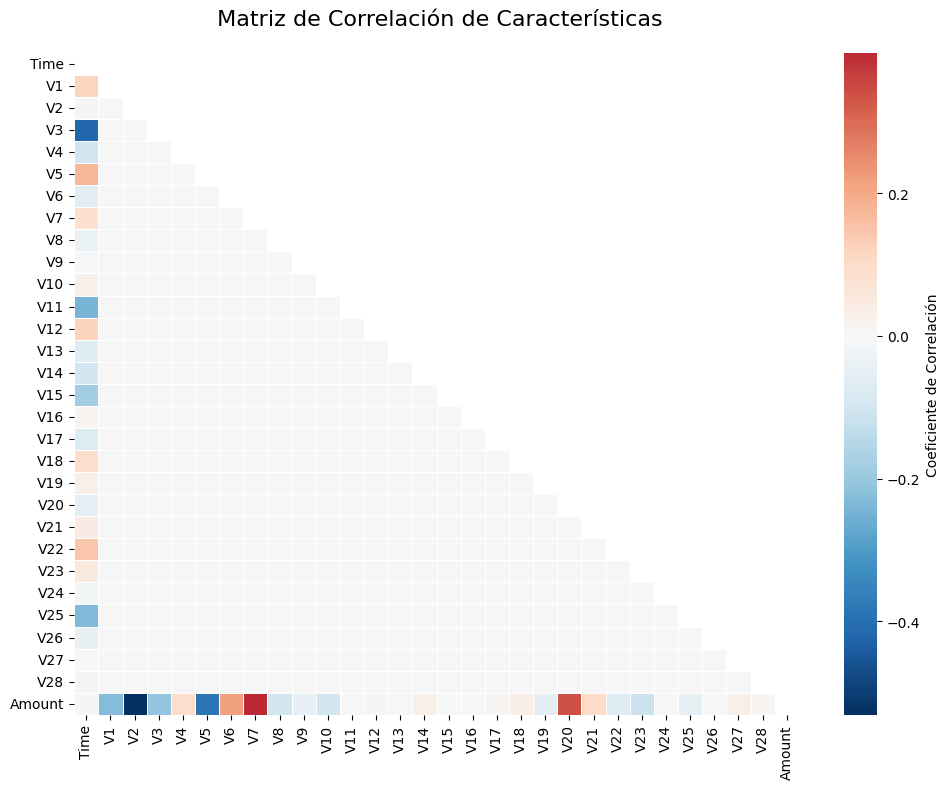

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asumimos que 'correlation_matrix' ya existe
# sns.set_theme(style="whitegrid", palette="viridis") #

# --- FIGURA 1: HEATMAP DE CORRELACIÓN ---
plt.figure(figsize=(10, 8)) # Tamaño ajustado para ser legible

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            cmap='RdBu_r', # Mapa de color divergente (rojo-blanco-azul)
            center=0,
            annot=False, # Annot=True sería ilegible con muchas features
            linewidths=.5,
            cbar_kws={'label': 'Coeficiente de Correlación'})

plt.title(' Matriz de Correlación de Características', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

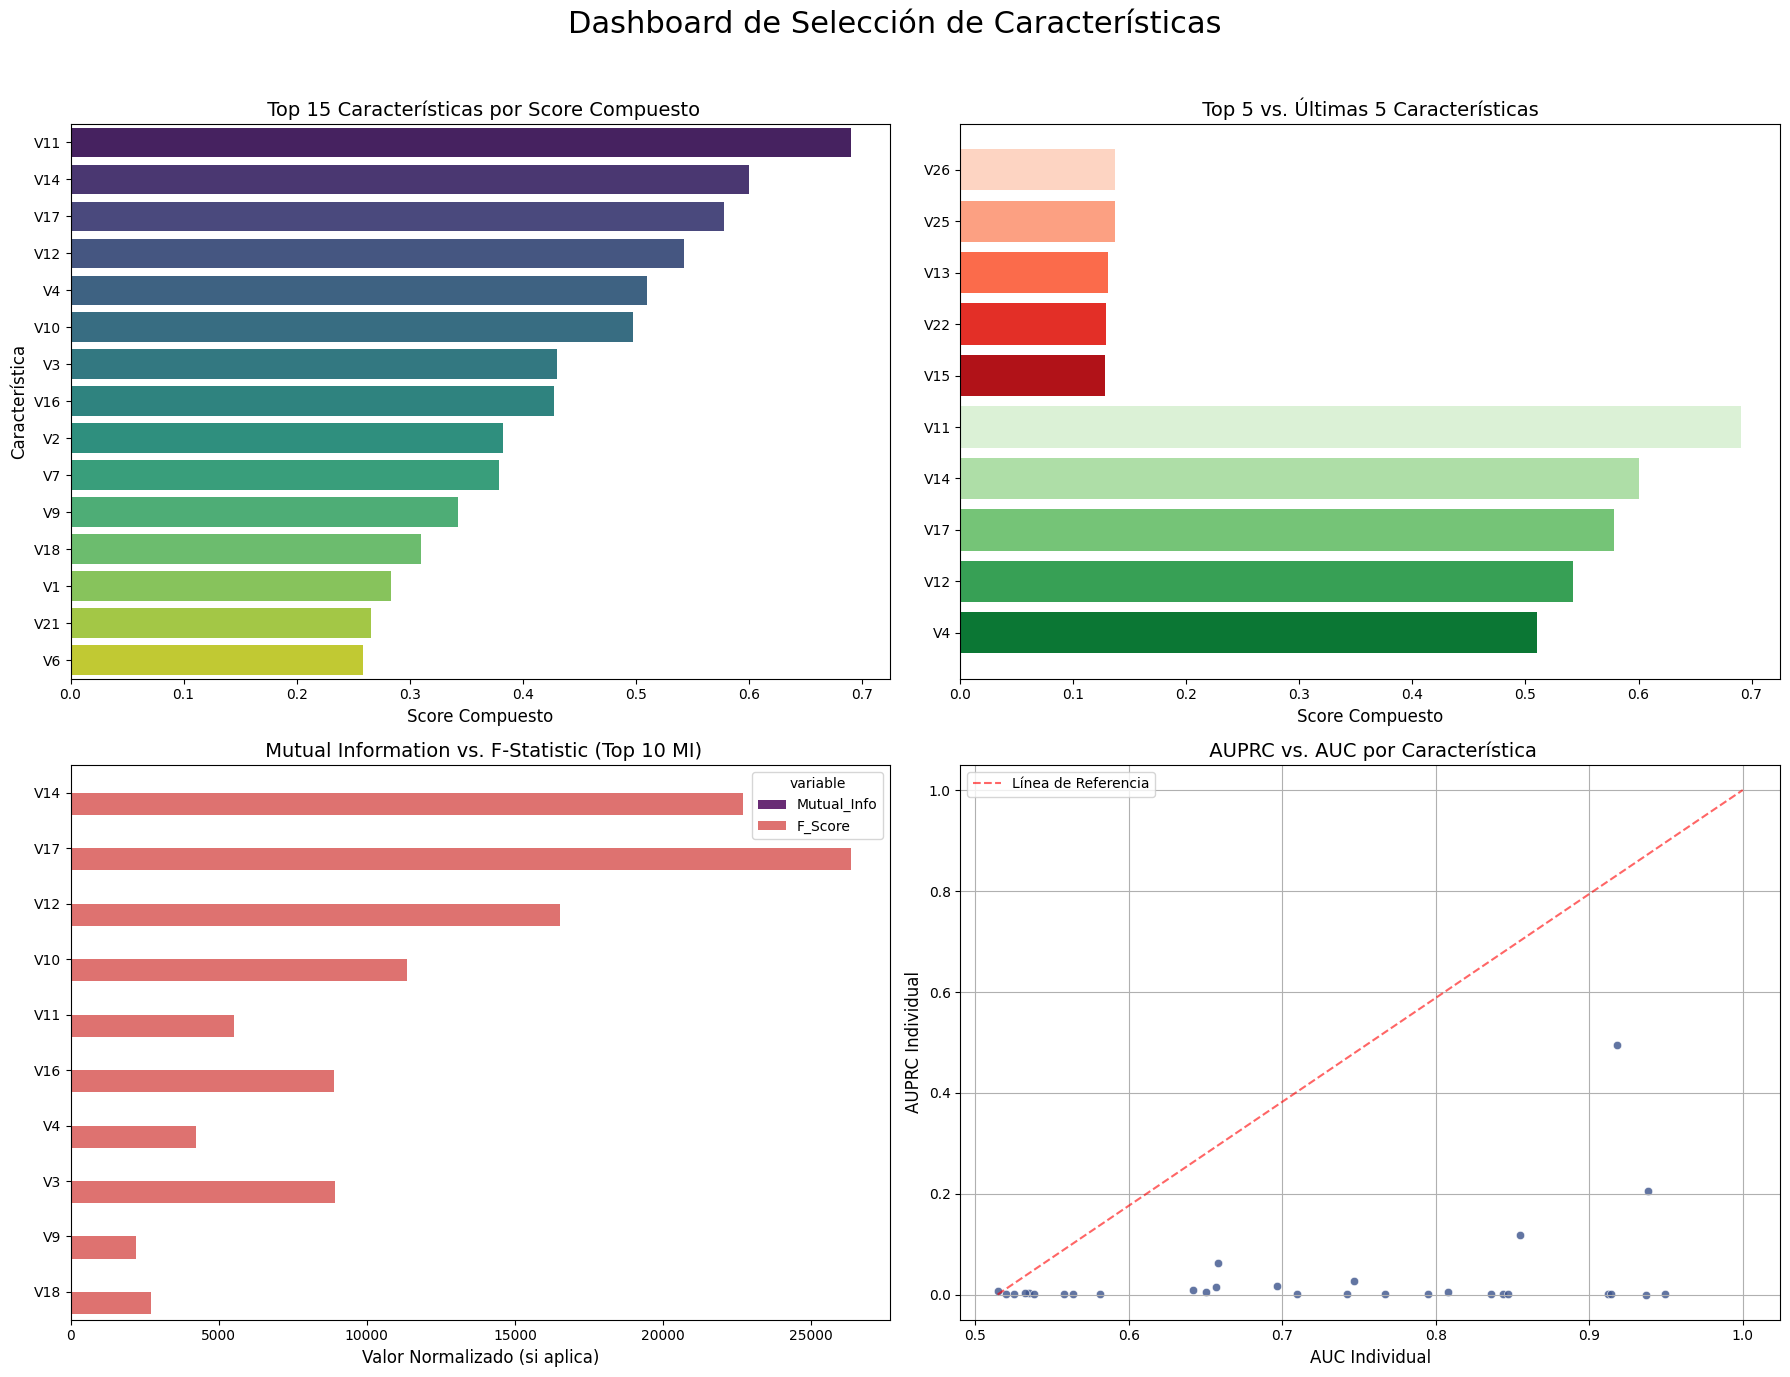

In [13]:
# --- FIGURA 2: PANEL DE ANÁLISIS DE CARACTERÍSTICAS ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Dashboard de Selección de Características', fontsize=22, y=0.98)

# --- Gráfico 1 : Top 15 Características por Score Compuesto ---
# En lugar de mostrar todas sin etiqueta, mostramos las 15 más importantes.
top_15_features = feature_scores.head(15)
sns.barplot(x=top_15_features['Composite_Score'], y=top_15_features.index,
            orient='h', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title(' Top 15 Características por Score Compuesto', fontsize=14)
axes[0, 0].set_xlabel('Score Compuesto', fontsize=12)
axes[0, 0].set_ylabel('Característica', fontsize=12)

# --- Gráfico 2 : Top 5 vs. Bottom 5 ---
# Usamos barh para mejor legibilidad.
top_5 = feature_scores.head(5)
bottom_5 = feature_scores.tail(5)
features_comparison = list(top_5.index)[::-1] + list(bottom_5.index)[::-1]
scores_comparison = list(top_5['Composite_Score'])[::-1] + list(bottom_5['Composite_Score'])[::-1]
colors = sns.color_palette("Greens_r", 5) + sns.color_palette("Reds_r", 5)

axes[0, 1].barh(range(len(features_comparison)), scores_comparison, color=colors)
axes[0, 1].set_yticks(range(len(features_comparison)))
axes[0, 1].set_yticklabels(features_comparison)
axes[0, 1].set_title(' Top 5 vs. Últimas 5 Características ', fontsize=14)
axes[0, 1].set_xlabel('Score Compuesto', fontsize=12)

# --- Gráfico 3 : Mutual Information vs. F-Statistic ---
# Combinamos MI y F-Score para comparar directamente su ranking.
top_10_mi = mi_df.head(10).set_index('Feature')
top_10_f = f_df.set_index('Feature')
combined_stats = top_10_mi.join(top_10_f).reset_index()
combined_stats_melted = combined_stats.melt(id_vars='Feature', value_vars=['Mutual_Info', 'F_Score'])

sns.barplot(x='value', y='Feature', hue='variable', data=combined_stats_melted,
            orient='h', ax=axes[1, 0], palette='magma')
axes[1, 0].set_title(' Mutual Information vs. F-Statistic (Top 10 MI)', fontsize=14)
axes[1, 0].set_xlabel('Valor Normalizado (si aplica)', fontsize=12)
axes[1, 0].set_ylabel('')

# --- Gráfico 4 : AUPRC vs. AUC ---
# Añadimos un grid para facilitar la lectura.
auprc_values = [individual_auprc[f] for f in feature_names]
auc_values = [individual_auc[f] for f in feature_names]
sns.scatterplot(x=auc_values, y=auprc_values, ax=axes[1, 1], alpha=0.8, color='#3b528b')
axes[1, 1].plot([min(auc_values), 1], [min(auprc_values), 1], 'r--', alpha=0.6, label='Línea de Referencia')
axes[1, 1].set_title(' AUPRC vs. AUC por Característica', fontsize=14)
axes[1, 1].set_xlabel('AUC Individual', fontsize=12)
axes[1, 1].set_ylabel('AUPRC Individual', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Ajuste final para evitar solapamientos
plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect deja espacio para el suptitle
plt.show()

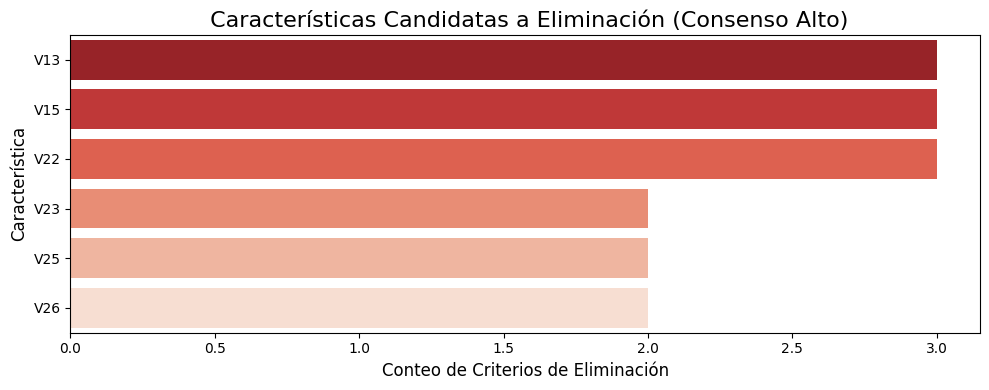

In [15]:
# --- FIGURA 3: CONSENSO DE ELIMINACIÓN ---
if high_consensus:
    consensus_features = list(high_consensus.keys())
    consensus_counts = list(high_consensus.values())

    plt.figure(figsize=(10, max(4, len(consensus_features) * 0.5))) # Altura dinámica
    sns.barplot(x=consensus_counts, y=consensus_features, orient='h', palette='Reds_r')
    plt.title(' Características Candidatas a Eliminación (Consenso Alto)', fontsize=16)
    plt.xlabel('Conteo de Criterios de Eliminación', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print(" No hay características con consenso alto para eliminación.")